# PostgresML tutorial

## Introduction

The overarching trend in machine learning is that data is moved to the model's environment for training. But what if we do that in reverse? Since today's databases are orders of magnitude larger than machine learning models, wouldn't it be much easier if we brought the models to the datasets? 

That's the core idea behind PostgresML - data stays put, you bring your code to the database. As you will discover soon, this type of reversed-logic machine learning brings a host of real-world benefits that will make you reconsider the idea of a "database". 

## What is PostgresML and why choose it?

PostgresML is a comprehensive machine learning platform built on top of the popular PostgreSQL database. It introduces a new paradigm called "In-database" machine learning, allowing you to perform many ML tasks without needing separate tools at each step. 

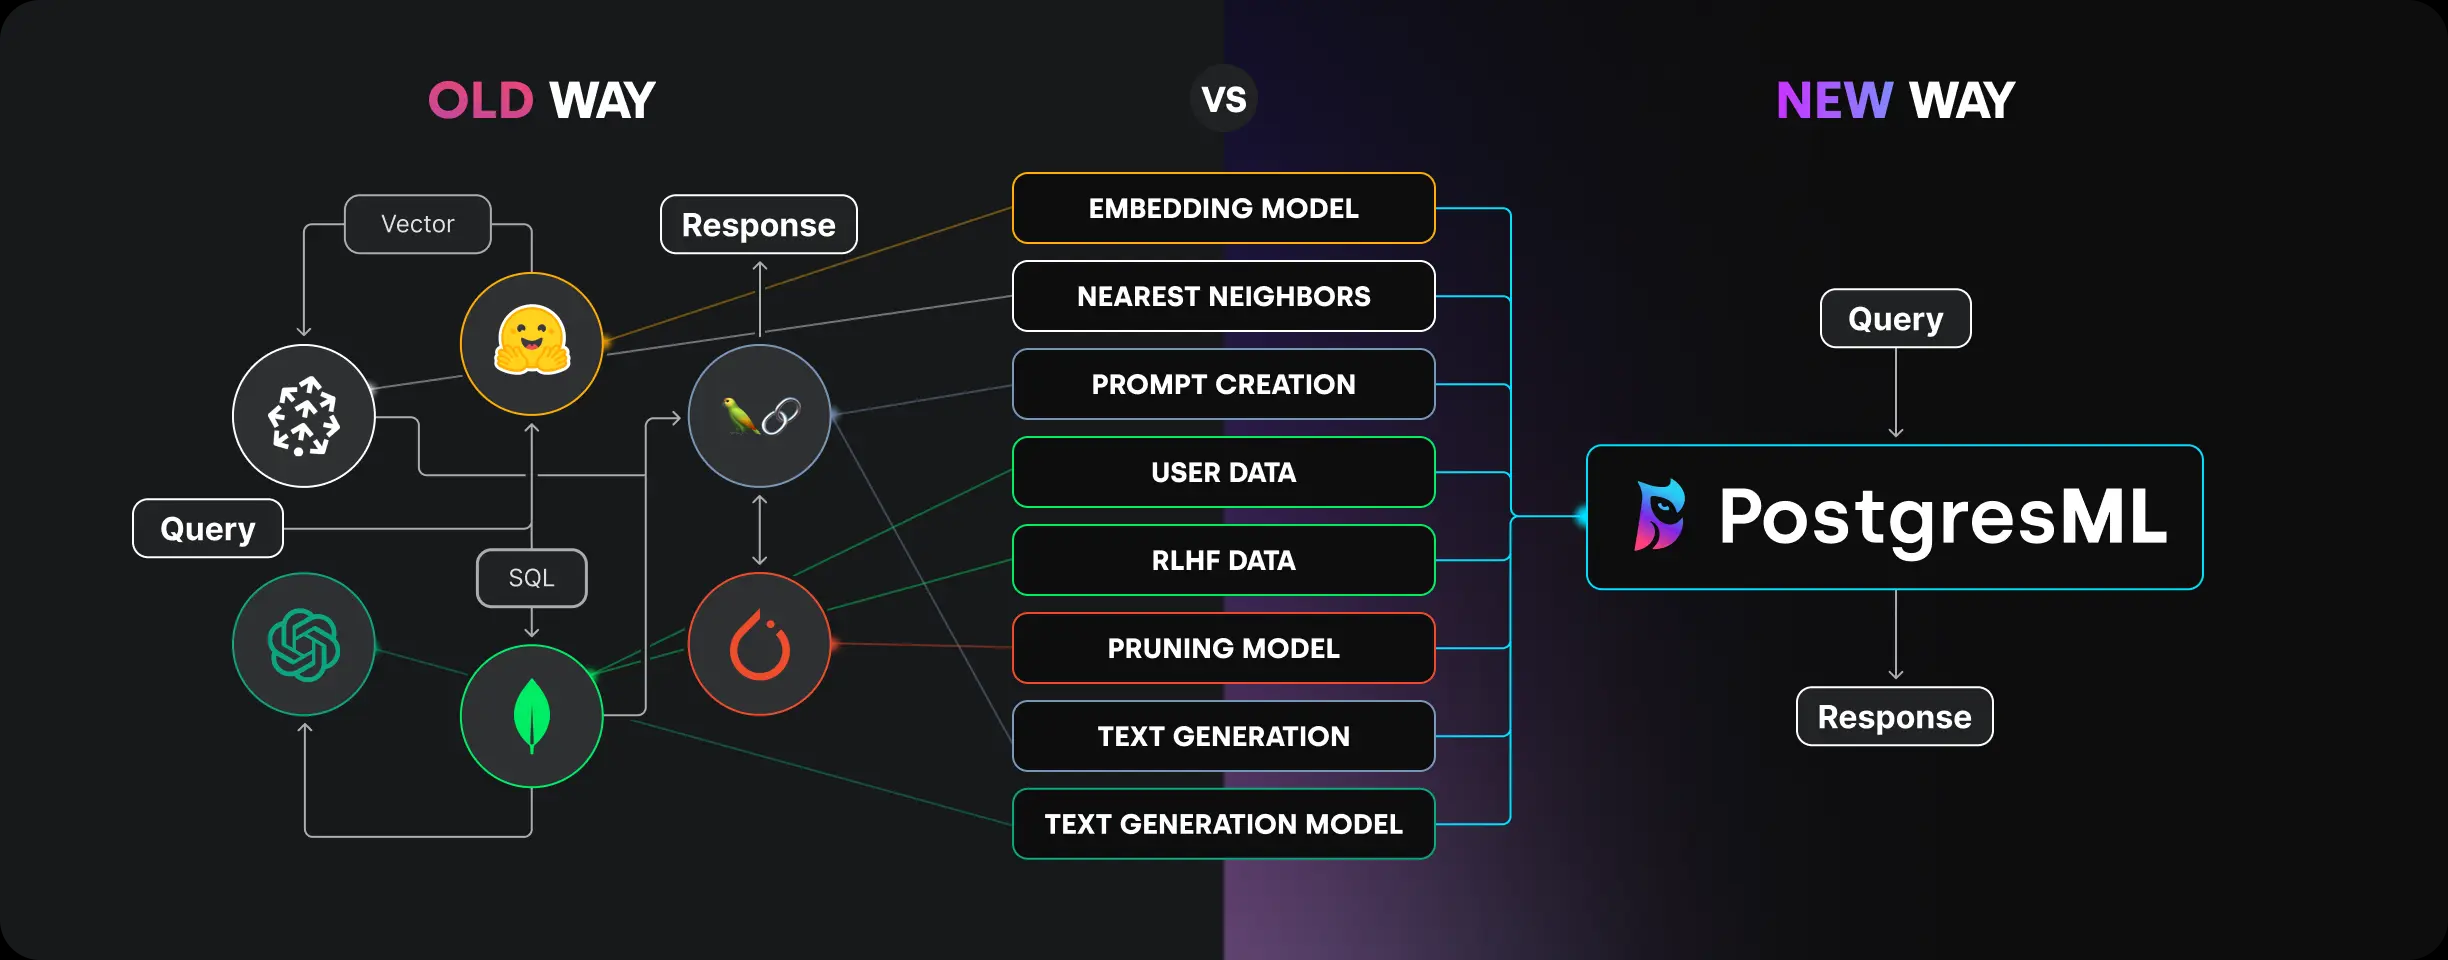

Despite being young, PostgresML promises these guaranteed benefits:

- In-database ML: It enables you to train, deploy, and run ML models directly within your PostgreSQL database. This eliminates the need to constantly move data between the database and external ML frameworks, improving efficiency and reducing latency at each step.
- SQL API: If you love both SQL and machine learning, postgresml.org may become your most favorite website on the Internet. The platform allows you to train, fine-tune and deploy machine learning models with SQL `SELECT` statements. For data analysts and scientists without extensive knowledge in half a dozen machine learning frameworks, this feature might completely redefine their day-to-day workflows. 
- Pre-trained models: PostgresML easily integrates with HuggingFace, giving it access to hundreds of pre-trained models such as Llama, Falcon, Bert, Mistral and so on. 
- Customization and flexibility: PostgresML supports over 50+ algorithms from Scikit-learn, XGBoost, LGBM, PyTorch, and TensorFlow. This enables you to train and deploy ML models on many supervised-learning tasks right in your database.
- Integration with existing ecosystems: Since PostgresML is essentially a database, you can interact with it in any environment that supports Postgres (basically anywhere). The platform also offers SDKs for 16 languages if doing ML in SQL is too weird for you (JavaScript, Python and Rust are best supported).

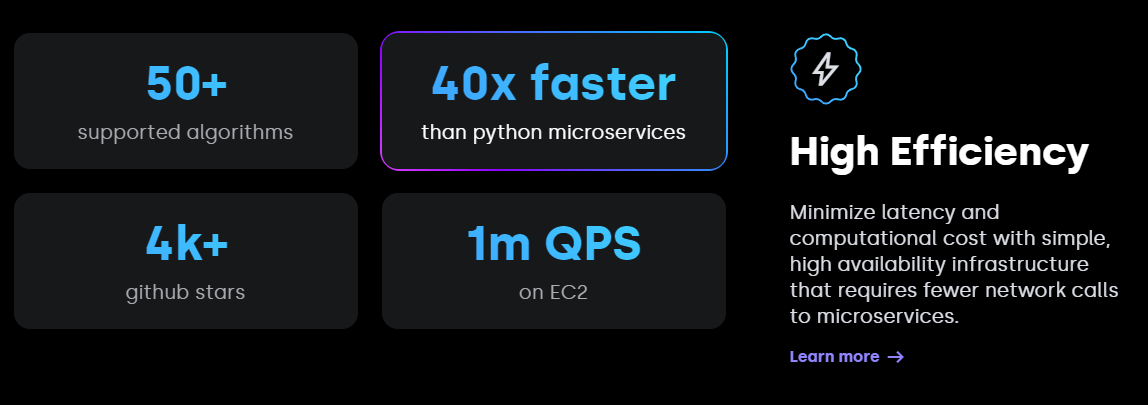

We will test-drive all these features in this tutorial by following a typical machine learning workflow:
1. Loading data
2. Preprocessing data
3. Training a model
4. Fine-tuning hyperparameters
5. Deploying it in production

All inside a Postgres database. Let's get started!

## An end-to-end ML workflow with PostgresML

This section is going to be short as all we need to know is some new SQL syntax dedicated to machine learning.

### 0. Sign up for PostgresML free tier

First, we will start by creating a free account at [https://postgresml.org/signup](https://postgresml.org/signup):

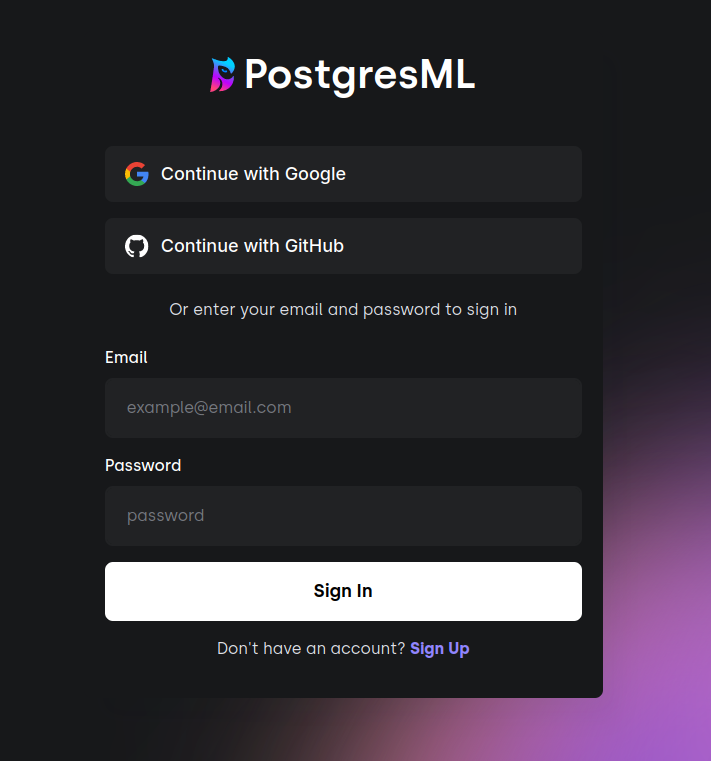

Then, choose the free tier which already gives some generous resources:

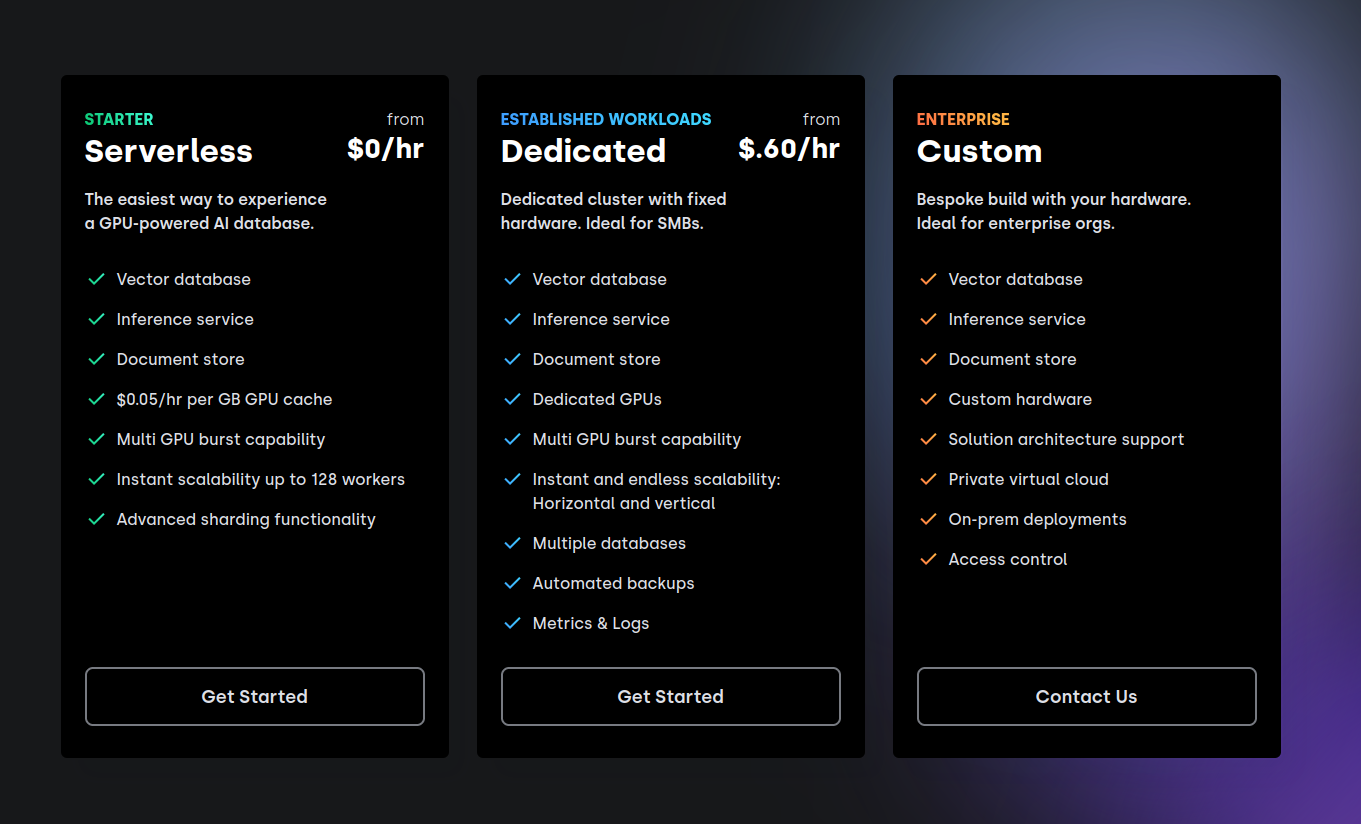

After sign-up is complete, you will land at your PostgresML console. This is where you manage different "In-database ML" projects and their related databases. 

![](images/console1.gif)

If you go to the "Manage" section, you will be able to scale your environment based on your compute requirements:

![](images/manage_resources.gif)

### 1. Install and setup Postgres

As the name suggests, we need PostgreSQL installed on our system to use PostgresML. If you don't know what [Postgres](https://www.postgresql.org/) is, it is the world's most advanced open-source database (that's what they say on their website). 

Here are links to platform-specific guides on PostgreSQL installation:

- [Windows](https://www.postgresql.org/download/windows/)
- [Mac OS](https://www.postgresql.org/download/macosx/)
- [Linux](https://www.devart.com/dbforge/postgresql/how-to-install-postgresql-on-linux/)

I am on WSL2, so I can just do:

```
$ sudo apt update
$ sudo apt install postgresql postgresql-contrib
$ sudo passwd postgres -- Set a new Postgres password
-- Close and reopen your terminal and done!
```

Afterwards, verify the installation with:

```
$ psql --version
```

```
psql (PostgreSQL) 12.18 (Ubuntu 12.18-0ubuntu0.20.04.1)
```

I understand that for most people, it is not ideal to run SQL in ugly terminals, so you can also install the following VSCode extension after installing Postgres:
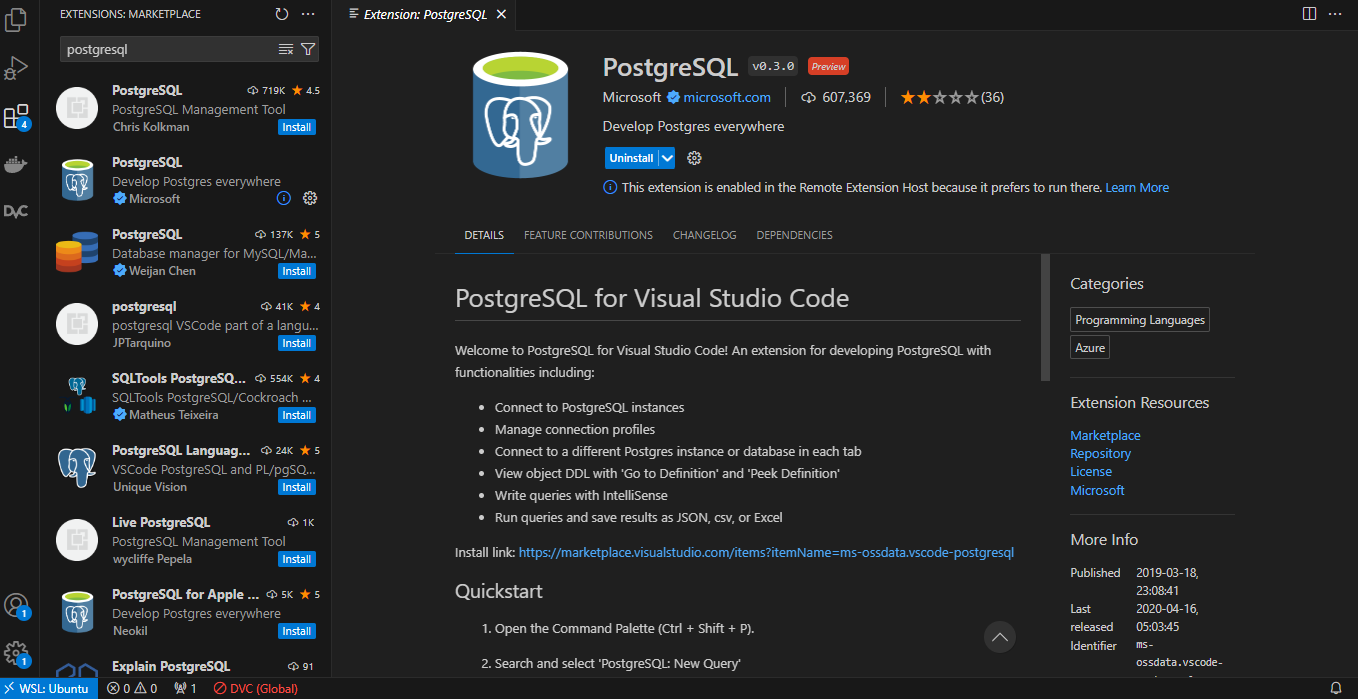

### 2. Connect to a database

Remember the landing page of your PostgresML console? Keep it open in a separate tab:

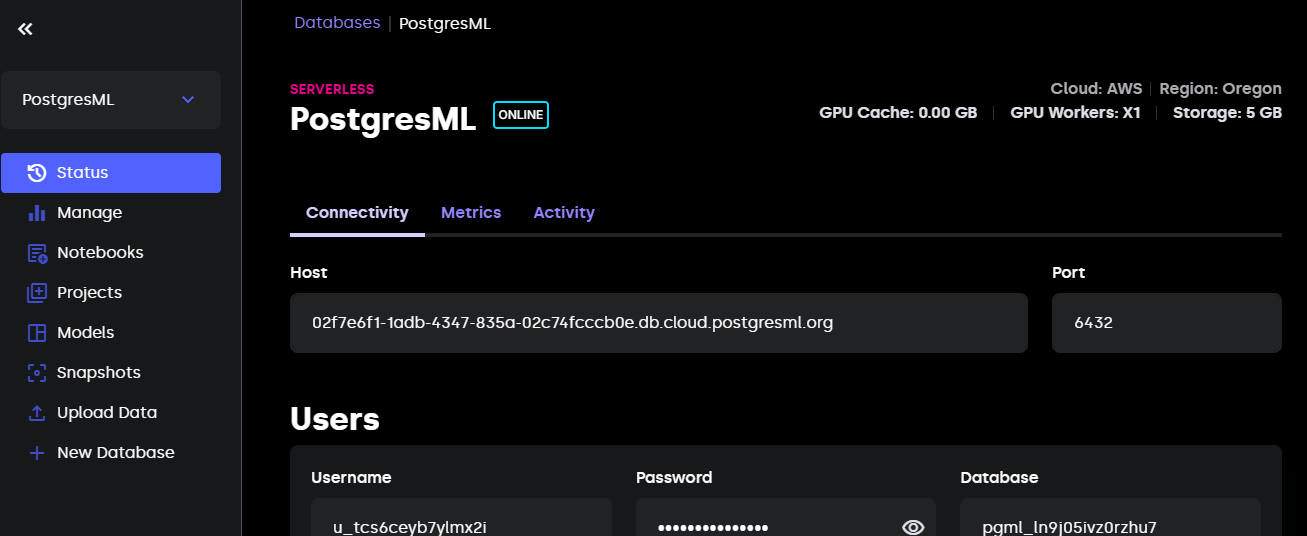

If you are using `psql` (the terminal client of Postgres), you can type the following command with your own credentials to establish a connection with PostgresML server:

```bash
$ psql -h "host" \
       -U "username" \
       -p 6432 \
       -d "database_name"
```

If you are using the VSCode extension, follow these steps (taken from the extension's installation page):

1. Open the Command Palette (Ctrl + Shift + P).
2. Search and select 'PostgreSQL: New Query'
3. In the command palette, select 'Create Connection Profile'. Follow the prompts to enter your Postgres instance's hostname, database, username, and password.

And you will be connected to the PostgresML database. 

The next step is creating the `pgml` extension that will allow us to run PostgresML functions:

```sql
CREATE EXTENSION IF NOT EXISTS pgml;
```

```
NOTICE:  extension "pgml" already exists, skipping
CREATE EXTENSIO
-- Your output may be different.N
```

Check if everything is successful by printing the `pgml` version:

```sql
SELECT pgml.version();
```

```
2.8.2 (98f114891db58acd472e068c44272b198274b11d)
```

### 3. Load the data

Now, let's load some data into our database. To keep things simple, we will only create a single table using the [Diamonds dataset](https://www.kaggle.com/datasets/shivam2503/diamonds) from Kaggle. You can download it as a CSV file from the website or using the Python snippet below:

In [ ]:
import seaborn as sns

diamonds = sns.load_dataset("diamonds")
diamonds.to_csv("diamonds.csv", index=False)

Then, run the following `CREATE` command with the correct schema:

```sql
CREATE TABLE IF NOT EXISTS diamonds (
    index SERIAL PRIMARY KEY,
    carat FLOAT,
    cut VARCHAR(255),
    color VARCHAR(255),
    clarity VARCHAR(255),
    depth FLOAT,
    table_ FLOAT,
    price INT,
    x FLOAT,
    y FLOAT,
    z FLOAT
)
```

The command will create a table named `diamonds`. Now, we can populate it with the rows in the CSV file:

```sql
INSERT INTO diamonds 
    (carat, cut, color, clarity, depth, table_, price, x, y, z) 
    FROM '~/full/path/to/diamonds.csv
    DELIMITER ',',
    CSV HEADER;
```

> Don't forget to update the full path to the CSV file.

Now, we can finally print the top of the table:

```sql
SELECT * FROM diamonds
 LIMIT 10;;
```

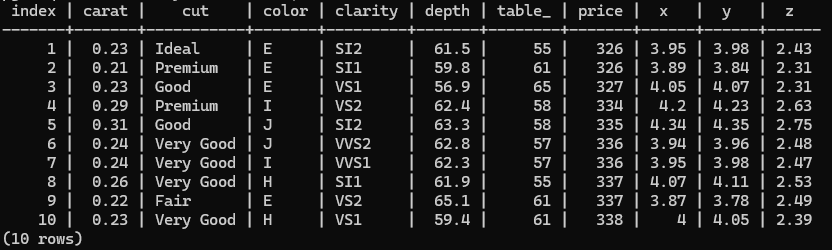

Now, we are ready to train a model!

### 4. Train a model

```sql
SELECT pgml.train(
  project_name => 'Diamond prices prediction',
  task => 'regression',
  relation_name => 'diamonds',
  y_column_name => 'price',
  algorithm => 'xgboost'
);
```

```sql
SELECT pgml.train(
  project_name => 'Diamond prices prediction',
  task => 'regression',
  relation_name => 'diamonds',
  y_column_name => 'price',
  algorithm => 'random_forest'
);
```

```sql
SELECT pgml.train(
  project_name => 'Diamond prices prediction',
  task => 'regression',
  relation_name => 'diamonds',
  y_column_name => 'price',
  algorithm => 'lightgbm'
);
```

```sql
SELECT pgml.train(
    project_name => 'Diamond prices prediction',
    task => 'regression',
    relation_name => 'diamonds',
    y_column_name => 'price',
    algorithm => 'xgboost',
    preprocess => '{
        "carat": {"scale": "standard"},
        "depth": {"scale": "standard"},
        "table_": {"scale": "standard"},
        "cut": {"encode": "target", "scale": "standard"},
        "color": {"encode": "target", "scale": "standard"},
        "clarity": {"encode": "target", "scale": "standard"}
    }'::JSONB
);
```

```sql
SELECT pgml.train(
    project_name => 'Diamond prices prediction',
    task => 'regression',
    relation_name => 'diamonds',
    y_column_name => 'price',
    algorithm => 'lightgbm',
    preprocess => '{
        "carat": {"scale": "standard"},
        "depth": {"scale": "standard"},
        "table_": {"scale": "standard"},
        "cut": {"encode": "target", "scale": "standard"},
        "color": {"encode": "target", "scale": "standard"},
        "clarity": {"encode": "target", "scale": "standard"}
    }'::JSONB
);
```

```sql
SELECT pgml.train(
    project_name => 'Diamond prices prediction',
    task => 'regression',
    relation_name => 'diamonds',
    y_column_name => 'price',
    algorithm => 'xgboost',
    hyperparams => '{
        "n_estimators": 1000, "max_depth": 5, "eta": 0.01, "subsample": 0.7
    }'::JSONB
);
```

```sql
SELECT pgml.predict(
    project_name => 'Diamond prices prediction',
    features => ARRAY[0.7, "Ideal", "A", "IF", 67.9, 56.9, 7024, 5.85, 5.87, 3.71]
);
```

### 5. Evaluate the model

### 6. Deploy the model

## Conclusion